<a href="https://colab.research.google.com/github/QuangVinhMSC/Brain-Tumor-Segmentation/blob/main/AutoFocusResUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/adrive')

Mounted at /content/adrive


In [ ]:
!pip install segmentation_models_3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 8.3 MB/s eta 0:00:00


#Unzip Data

In [ ]:
!unzip /content/adrive/MyDrive//ANN/archive.zip

Archive:  /content/adrive/MyDrive//ANN/archive.zip
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_flair.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1ce.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t2.nii

#Load sample images and visualize

In [ ]:
import tensorflow as tf
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

#Combine every useful channel and crop the volumn into shape of 128 x 128 x 128

#Apply the same as above to all the images

In [ ]:
#ham tim can thiet
def canthiet():
    t2_list_new=[]
    t1ce_list_new=[]
    flair_list_new=[]
    mask_list_new=[]
    t2_list = sorted(glob.glob('/content/MICCAI_BraTS_2019_Data_Training/*/*/*t2.nii'))
    t1ce_list = sorted(glob.glob('/content/MICCAI_BraTS_2019_Data_Training/*/*/*t1ce.nii'))
    flair_list = sorted(glob.glob('/content/MICCAI_BraTS_2019_Data_Training/*/*/*flair.nii'))
    mask_list = sorted(glob.glob('/content/MICCAI_BraTS_2019_Data_Training/*/*/*seg.nii'))
    for img in range(len(t2_list)):
        temp_mask=nib.load(mask_list[img]).get_fdata()
        temp_mask=temp_mask.astype(np.uint8)
        temp_mask[temp_mask==4] = 3
        temp_mask = temp_mask[56:184, 56:184, 13:141]
        val, counts = np.unique(temp_mask, return_counts=True)
        if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
            t2_list_new.append(t2_list[img])
            t1ce_list_new.append(t1ce_list[img])
            flair_list_new.append(flair_list[img])
            mask_list_new.append(mask_list[img])
    return t2_list_new,t1ce_list_new,flair_list_new,mask_list_new

In [ ]:
t2_list,t1ce_list,flair_list,mask_list = canthiet()

In [ ]:
len(t2_list)

311

In [ ]:
def normalize(im_input):
    x_start = im_input.shape[0] // 4
    x_range = im_input.shape[0] // 2
    y_start = im_input.shape[1] // 4
    y_range = im_input.shape[1] // 2
    z_start = im_input.shape[2] // 4
    z_range = im_input.shape[2] // 2
    roi = im_input[x_start : x_start + x_range, y_start : y_start + y_range, z_start : z_start + z_range]
    im_output = (im_input - np.mean(roi)) / np.std(roi)
    return im_output

In [ ]:
import numpy as np
temp_image_t2=nib.load(t2_list[0]).get_fdata()
print(temp_image_t2.shape)
# print(np.any(max(temp_image_t2)))
nor = normalize(temp_image_t2)
print(type(nor))
print("co gia tri anh nao lon hon 5 khong:",np.any(nor>=5))


(240, 240, 155)
<class 'numpy.ndarray'>
co gia tri anh nao lon hon 5 khong: False


In [ ]:
#lay data
def laydata(index):
    temp_image_t2=nib.load(t2_list[index]).get_fdata()
    temp_image_t2=normalize(temp_image_t2)[56:184, 56:184, 13:141]
    symmetric_t2_i = np.flip(temp_image_t2,axis=0)
    symmetric_t2_j = np.flip(temp_image_t2,axis=1)
    symmetric_t2_i = temp_image_t2 - symmetric_t2_i
    symmetric_t2_j = temp_image_t2 - symmetric_t2_j
    # IS_t2 = np.concatenate((temp_image_t2,symmetric_t2_i,symmetric_t2_j),axis = 2)
    IS_t2 = temp_image_t2 + symmetric_t2_i + symmetric_t2_j

    temp_image_t1ce=nib.load(t1ce_list[index]).get_fdata()
    temp_image_t1ce=normalize(temp_image_t1ce)[56:184, 56:184, 13:141]
    symmetric_t1ce_i = np.flip(temp_image_t1ce,axis=0)
    symmetric_t1ce_j = np.flip(temp_image_t1ce,axis=1)
    symmetric_t1ce_i = temp_image_t1ce - symmetric_t1ce_i
    symmetric_t1ce_j = temp_image_t1ce - symmetric_t1ce_j
    # IS_t1ce = np.concatenate((temp_image_t1ce,symmetric_t1ce_i,symmetric_t1ce_j),axis = 2)
    IS_t1ce = temp_image_t1ce + symmetric_t1ce_i + symmetric_t1ce_j


    temp_image_flair=nib.load(flair_list[index]).get_fdata()
    temp_image_flair=normalize(temp_image_flair)[56:184, 56:184, 13:141]
    symmetric_flair_i = np.flip(temp_image_flair,axis=0)
    symmetric_flair_j = np.flip(temp_image_flair,axis=1)
    symmetric_flair_i = temp_image_t2 - symmetric_flair_i
    symmetric_flair_j = temp_image_t2 - symmetric_flair_j
    # IS_flair= np.concatenate((temp_image_flair,symmetric_flair_i,symmetric_flair_j),axis = 2)
    IS_flair= temp_image_flair + symmetric_flair_i + symmetric_flair_j

    temp_mask=nib.load(mask_list[index]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    IS_combined = np.stack([IS_flair,IS_t1ce,IS_t2],axis = 3)
    val, counts = np.unique(temp_mask, return_counts=True)
    temp_mask= to_categorical(temp_mask, num_classes=4)
    return temp_combined_images,temp_mask,IS_combined

In [ ]:
# #tạo các patch
# def laypatch(temp_combined_images,symmetric_Ii,symmetric_Ij,temp_mask):
#     l_patch = []
#     l_patch_sym = []
#     l_patch_msk = []
#     X = [32,59,59,59]
#     Y = [32,59,59,59]
#     Z = [32,45,46]
#     for x in X:
#         for y in Y:
#             for z in Z:
#                 patch_img = temp_combined_images[x-32:x+32,y-32:y+32,z-32:z+32,:]
#                 patch_sym_i = symmetric_Ii[x-32:x+32,y-32:y+32,z-32:z+32,:]
#                 patch_sym_j = symmetric_Ij[x-32:x+32,y-32:y+32,z-32:z+32,:]
#                 patch_sym = np.concatenate([patch_img,patch_sym_i,patch_sym_j],axis = 2)
#                 patch_mask = temp_mask[x-32:x+32,y-32:y+32,z-32:z+32]
#                 l_patch.append(patch_img)
#                 l_patch_sym.append(patch_sym)
#                 l_patch_msk.append(patch_mask)
#     return l_patch,l_patch_sym,l_patch_msk

In [ ]:
# List_index = np.arange(0,310).tolist()
# list_patch = []
# list_patch_sym = []
# list_patch_msk = []
# for index in List_index:
#     temp_combined_images,symmetric_Ii,symmetric_Ij,temp_mask = laydata(index)
#     l_patch,l_patch_sym,l_patch_msk = laypatch(temp_combined_images,symmetric_Ii,symmetric_Ij,temp_mask)
#     list_patch.extend(l_patch)
#     list_patch_sym.extend(l_patch_sym)
#     list_patch_msk.extend(l_patch_msk)

In [ ]:
def batchdata(list_index):
    img_list = []
    mask_list = []
    IS_list = []
    for index in list_index:
        img,mask,IS = laydata(index)
        img_list.append(img)
        mask_list.append(mask)
        IS_list.append(IS)
    img_list = np.array(img_list)
    mask_list = np.array(mask_list)
    IS_list = np.array(IS_list)
    return img_list,mask_list,IS_list

#Custom data generator

In [ ]:

#from tifffile import imsave, imread
import os

def imageLoader(list_index, batch_size):

    L = len(list_index)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X,Y,I = batchdata(list_index[batch_start:limit])

            yield (X,Y,I) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size


In [ ]:
# import random
# list_index = [2,5,10,30,78,200]
# batch_size = 5
# Img = imageLoader(list_index, batch_size)
# img, msk = Img.__next__()

# print(img.shape)
# print(msk.shape)

# **Define ResBlock AutoFocusBlock, ConvBlock**

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers,Model
from tensorflow import keras

def res_conv_block(x, kernel_size, channels, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv3D(channels, (kernel_size,kernel_size, kernel_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=4)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv3D(channels, (kernel_size,kernel_size, kernel_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=4)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv3D(channels, kernel_size=(1, 1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=4)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv3D(size, (filter_size,filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=4)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv3D(size, (filter_size,filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=4)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv
def autofocus_single(x, inplanes1, outplanes1, outplanes2, padding_list, dilation_list, num_branches, kernel=3):
    padding_layers = [layers.ZeroPadding3D(padding) for padding in padding_list]
    residual = x
    x = layers.Conv3D(outplanes1, padding='same', kernel_size=kernel, dilation_rate=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Compute attention weights for the second layer
    feature = x
    att = layers.ReLU()(layers.Conv3D(outplanes1 // 2, padding='same', kernel_size=kernel)(feature))
    att = layers.Conv3D(num_branches, padding='same', kernel_size=1)(att)
    att = layers.Softmax(axis=-1)(att)

    # Linear combination of different dilation rates
    x1 = layers.Conv3D(outplanes2, padding='same', kernel_size=kernel, dilation_rate=dilation_list[0])(x)
    x1 = layers.BatchNormalization()(x1) * layers.Lambda(lambda x: x[:, :, :, :, 0:1])(att)

    for i in range(1, num_branches):
        x2 = layers.Conv3D(outplanes2, kernel_size=1, dilation_rate=dilation_list[i])(x)
        x2 = layers.BatchNormalization()(x2)
        x1 += x2 * att[:, :, :, :, i:(i+1)]

    if inplanes1 != outplanes2:
        downsample = tf.keras.Sequential()
        downsample.add(layers.Conv3D(outplanes2, padding='same', kernel_size=1))
        downsample.add(layers.BatchNormalization())
        residual = downsample(residual)

    x = x1 + residual
    x = layers.ReLU()(x)
    return x

**Define Architecture**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    # network structure
    FILTER_NUM = 16 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    kernel_size = 3
    num_branches = 4

    #Build the model
    inputs1 = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    inputs2 = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s1 = inputs1
    s2 = inputs2

    #Contraction path 1
    c11 = conv_block(s1,FILTER_SIZE,FILTER_NUM*2,dropout=0.2,batch_norm=True)
    # a1 = autofocus_single(c1,inplanes1=FILTER_NUM*2,outplanes1=FILTER_NUM*2,outplanes2=FILTER_NUM*2,num_branches=4,padding_list=[0,4,8,12],dilation_list=[2,6,10,14])
    p11 = MaxPooling3D((2, 2, 2))(c11)

    c21 = res_conv_block(p11,FILTER_SIZE,FILTER_NUM*4,dropout=0.1,batch_norm=True)
    # a2 = autofocus_single(c2,inplanes1=FILTER_NUM*4,outplanes1=FILTER_NUM*4,outplanes2=FILTER_NUM*2,num_branches=4,padding_list=[0,4,8,12],dilation_list=[2,6,10,14])
    p21 = MaxPooling3D((2, 2, 2))(c21)

    c31 = res_conv_block(p21,FILTER_SIZE,FILTER_NUM*8,dropout=0.2,batch_norm=True)
    # a3 = autofocus_single(c3,inplanes1=FILTER_NUM*8,outplanes1=FILTER_NUM*8,outplanes2=FILTER_NUM*4,num_branches=4,padding_list=[0,4,8,12],dilation_list=[2,6,10,14])
    p31 = MaxPooling3D((2, 2, 2))(c31)

    #Contraction path 2
    c12 = conv_block(s2,FILTER_SIZE,FILTER_NUM*2,dropout=0.2,batch_norm=True)
    # a1 = autofocus_single(c1,inplanes1=FILTER_NUM*2,outplanes1=FILTER_NUM*2,outplanes2=FILTER_NUM*2,num_branches=4,padding_list=[0,4,8,12],dilation_list=[2,6,10,14])
    p12 = MaxPooling3D((2, 2, 2))(c12)

    c22 = res_conv_block(p12,FILTER_SIZE,FILTER_NUM*4,dropout=0.1,batch_norm=True)
    # a2 = autofocus_single(c2,inplanes1=FILTER_NUM*4,outplanes1=FILTER_NUM*4,outplanes2=FILTER_NUM*2,num_branches=4,padding_list=[0,4,8,12],dilation_list=[2,6,10,14])
    p22 = MaxPooling3D((2, 2, 2))(c22)

    c32 = res_conv_block(p22,FILTER_SIZE,FILTER_NUM*8,dropout=0.2,batch_norm=True)
    # a3 = autofocus_single(c3,inplanes1=FILTER_NUM*8,outplanes1=FILTER_NUM*8,outplanes2=FILTER_NUM*4,num_branches=4,padding_list=[0,4,8,12],dilation_list=[2,6,10,14])
    p32 = MaxPooling3D((2, 2, 2))(c32)

    sum = p31 * p32

    c4 = res_conv_block(sum,FILTER_SIZE,FILTER_NUM*16,dropout=0.3,batch_norm=True)

    # c4 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    # c4 = Dropout(0.3)(c4)
    # c4 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)

    #Expansive path
    u5 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c4)
    u5 = concatenate([u5, c31])
    c5 = conv_block(u5, FILTER_SIZE, 8*FILTER_NUM, dropout=0.2, batch_norm=True)

    u6 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c21])
    c6 = conv_block(u6, FILTER_SIZE, 4*FILTER_NUM, dropout=0.2, batch_norm=True)

    u7 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c11])
    c7 = conv_block(u7, FILTER_SIZE, 2*FILTER_NUM, dropout=0.1, batch_norm=True)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c7)

    model = Model(inputs=[inputs1,inputs2], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    # model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 3, 4)
# print(model.input_shape)
# print(model.output_shape)



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  2624        ['input_1[0][0]']                
                                8, 32)                                                        

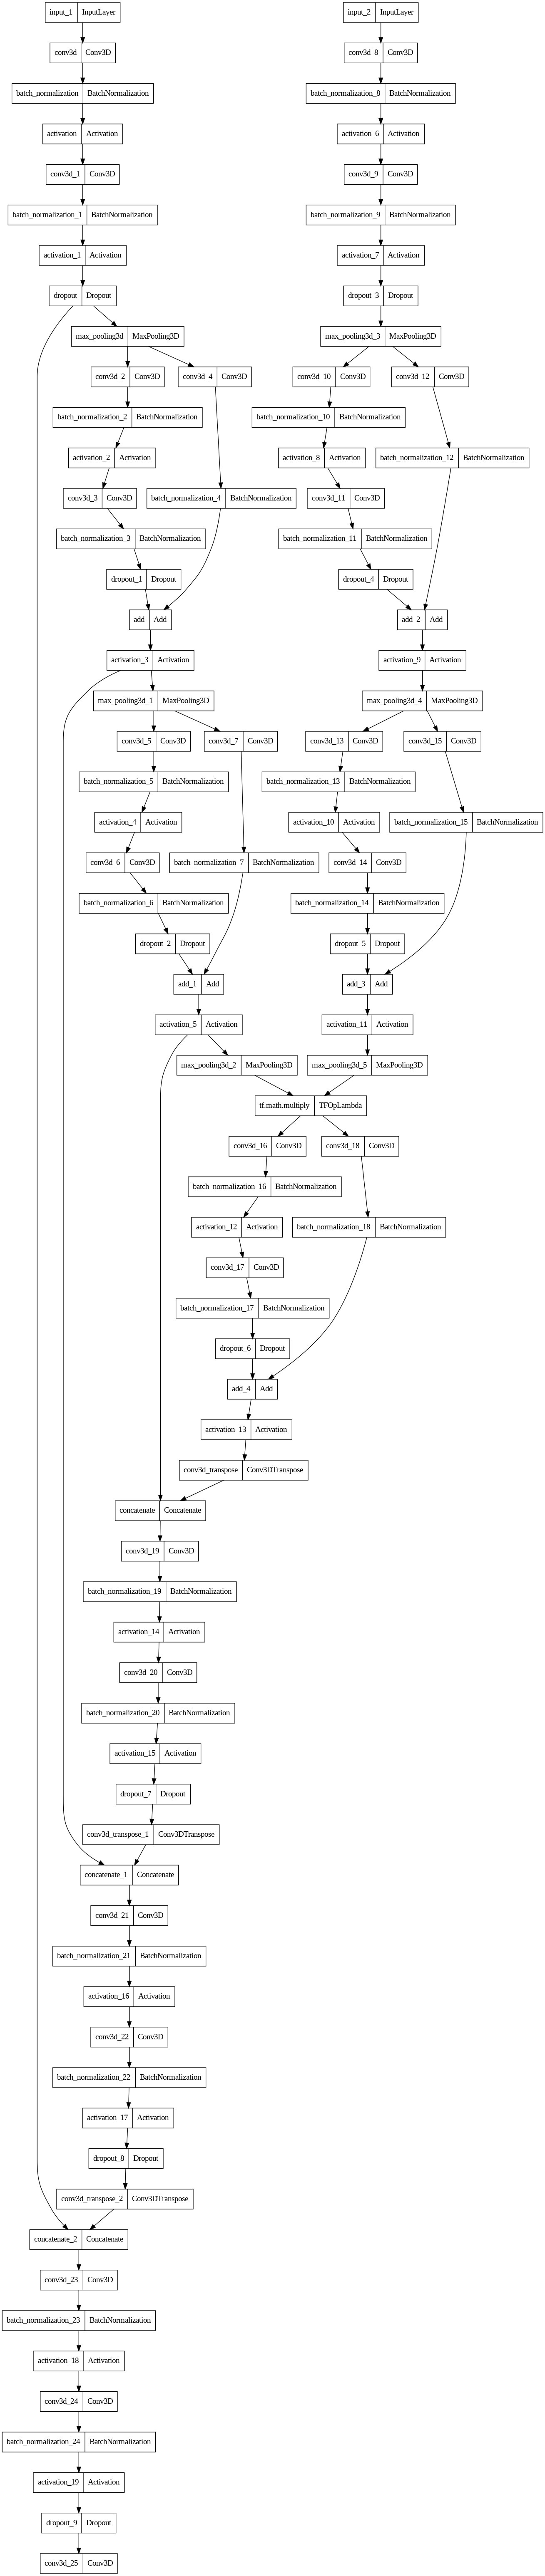

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model)

In [ ]:
from keras import backend as K
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,1] * y_pred[:,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,:,1])) + epsilon)
def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,2] * y_pred[:,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,:,2])) + epsilon)
def dice_coef_active(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,3] * y_pred[:,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,:,3])) + epsilon)
def dice_coef_background(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,0] * y_pred[:,:,:,:,0]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,0])) + K.sum(K.square(y_pred[:,:,:,:,0])) + epsilon)

In [ ]:
import random
List_index = np.arange(0,310).tolist()
random.shuffle(List_index)
List_index_train = List_index[0:216]
List_index_val = List_index[216:]

In [ ]:
import os
import numpy as np
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

num_images = len(t2_list)

batch_size = 1

train_img_datagen = imageLoader(List_index_train, batch_size)

val_img_datagen = imageLoader(List_index_val, batch_size)


###########################################################################
#Define loss, metrics and optimizer to be used for training
# 0.25,82.09,42.07,70.89 # Imbalance rate between classes
# 0.0012,0.4203,0.2154,0.3629 # scale rate to [0,1]
wt0, wt1, wt2, wt3 = 0.0012,0.4203,0.2154,0.3629

import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [dice_coef_background,dice_coef_necrotic, dice_coef_edema, dice_coef_active, sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)
#######################################################################
#Fit the model

steps_per_epoch = len(List_index_train)//batch_size
val_steps_per_epoch = len(List_index_val)//batch_size


model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
# print(model.summary())

print(model.input_shape)
print(model.output_shape)



##################################################################

Segmentation Models: using `tf.keras` framework.
[(None, 128, 128, 128, 3), (None, 128, 128, 128, 3)]
(None, 128, 128, 128, 4)


In [ ]:
len(train_img_datagen.__next__())

3

In [ ]:
history=model.fit(x=[train_img_datagen.__next__()[0],train_img_datagen.__next__()[2]],
                  y=train_img_datagen.__next__()[1],
                  steps_per_epoch=steps_per_epoch,
                  epochs=30,
                  verbose=1,
                  validation_data=val_img_datagen,
                  validation_steps=val_steps_per_epoch,
                  )

Epoch 1/30
 30/216 [===>..........................] - ETA: 5:32 - loss: 1.0198 - dice_coef_background: 0.5945 - dice_coef_necrotic: 0.0940 - dice_coef_edema: 0.1408 - dice_coef_active: 0.3765 - iou_score: 0.1318

ValueError: ignored

In [ ]:
model.save('/content/adrive/MyDrive/ANN/Data/resunet1.hdf5')

<ipython-input-18-ceeb02569b04>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)
<ipython-input-18-ceeb02569b04>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


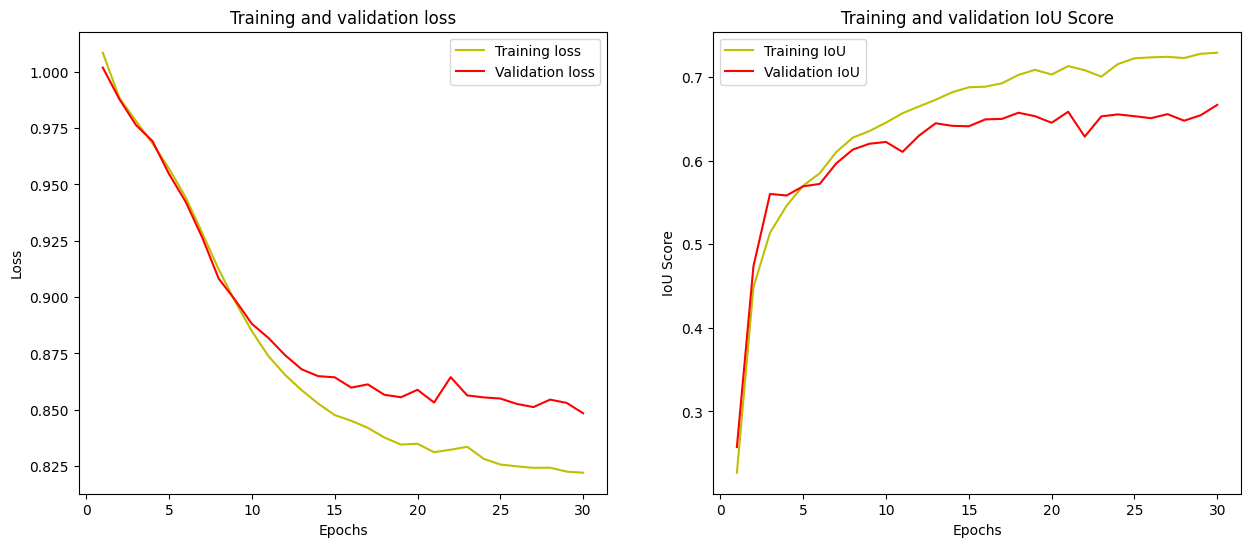

In [ ]:
#plot the training and validation IoU and loss at each epoch
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
plt.subplot(121)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.show()

plt.subplot(122)
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.title('Training and validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
my_model = load_model("/content/adrive/MyDrive/ANN/Data/resunet1.hdf5",
                      custom_objects={"dice_loss_plus_1focal_loss": total_loss,
                                      "iou_score":sm.metrics.IOUScore(threshold=0.5),
                                      "dice_coef_background":dice_coef_background,
                                      "dice_coef_necrotic":dice_coef_necrotic,
                                      "dice_coef_edema":dice_coef_edema,
                                      "dice_coef_active":dice_coef_active})

#Now all set to continue the training process.

In [ ]:
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

In [ ]:
#################################################

#For predictions you do not need to compile the model, so ...
my_model = load_model("/content/adrive/MyDrive/ANN/Data/resunet1.hdf5",
                      compile=False)


# Verify IoU on a batch of images from the test dataset
# Using built in keras function for IoU
# Only works on TF > 2.0
# from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(List_index_val, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 122s 122s/step
Mean IoU = 0.8070395


1/1 [==============================] - 24s 24s/step
(128, 128, 128)
(128, 128, 128)
[0 1 2 3]


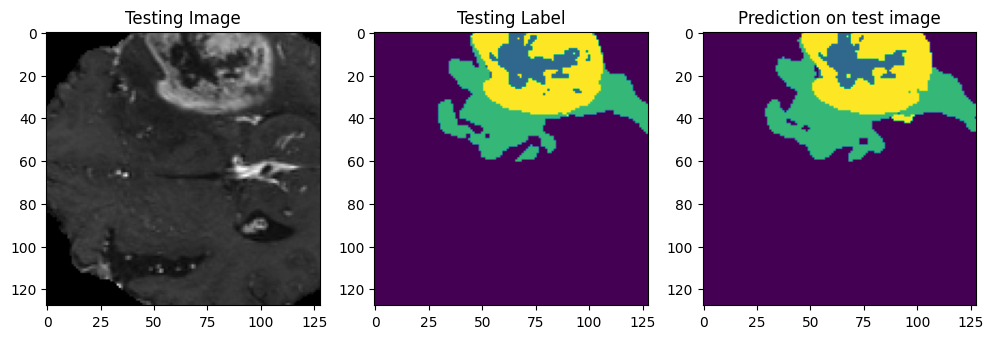

In [ ]:
def testing(img_num):
  #Predict on a few test images, one at a time
  test_img,test_mask = laydata(img_num)
  test_mask_argmax=np.argmax(test_mask, axis=3)
  test_img_input = np.expand_dims(test_img, axis=0)
  test_prediction = my_model.predict(test_img_input)
  test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

  print(test_prediction_argmax.shape)
  print(test_mask_argmax.shape)
  print(np.unique(test_prediction_argmax))

  #Plot individual slices from test predictions for verification
  from matplotlib import pyplot as plt
  import random

  #n_slice=random.randint(0, test_prediction_argmax.shape[2])
  n_slice = 55
  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(test_mask_argmax[:,:,n_slice])
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(test_prediction_argmax[:,:, n_slice])
  plt.show()

testing(113)